# <center>TMVA Classification Using BDT</center>

In this notebook we still classify di-Higgs new data with Boosted Decision Trees meethod.

In [11]:
import ROOT
from ROOT import TMVA, TTree
from ROOT import TCanvas, TColor, TGaxis, TH1F, TPad

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import itertools

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from array import array
from root_numpy import root2array, tree2array
import numpy as np
import pandas as pd

from IPython.display import Image, display


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_1tag", "Xtohh1000")

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_SR_1tag_Xtohh1000", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [31]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

There are:
- 79336 signal events
- 231046 background events

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [32]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70%:nTrain_Background=70%:SplitMode=Random:"
                                   "NormMode=NumEvents:!V")

## BDT

In [33]:
## Boosted Decision Trees
factory.BookMethod(loader, ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=3000:MinNodeSize=5%:MaxDepth=1:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20:VarTransform=N_AllClasses")

<ROOT.TMVA::MethodBDT object ("BDT") at 0xb9cfae0>

## Train, Test and Evaluate Methods

In [34]:
factory.TrainAllMethods()

# Here we test all methods using the test data set
factory.TestAllMethods()

# Here we evaluate all methods and compare their performances, computing efficiencies, 
# ROC curves etc.. using both training and tetsing data sets. Several histograms are 
#produced which can be examined with the TMVAGui or directly using the output file
factory.EvaluateAllMethods()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT            : 0.788
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

## Plot ROC Curve
We enable JavaScript visualisation for the plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0


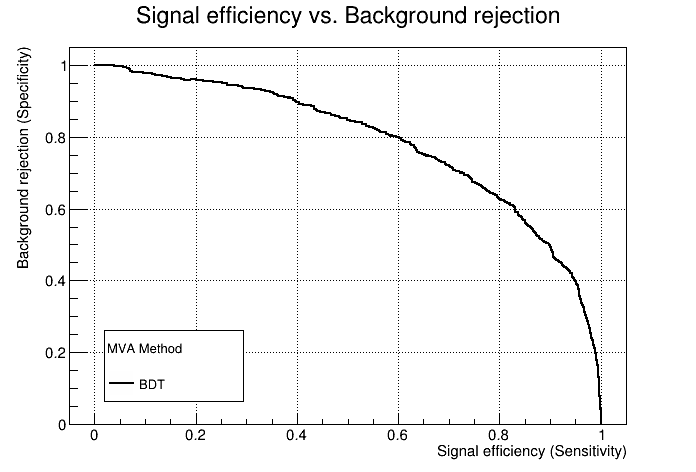

In [35]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## BDT Complete Function

In [4]:
def get_params(file):
    params = []
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [20]:
def BDT(params, training, config, comb=''):
    
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    output_file = config+"_"+comb+"_BDT_Classification.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_"+config+"_"+comb, outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetWeightExpression("EventWeight")

    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    ## Boosted Decision Trees
    factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT", params)
    
    #loader.OptimizeTuningParameters("ROCIntegral","FitGA")
    
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    #c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "BDT")
    
    # print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [6]:
def write_combs_params(file_params, file_training, arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background):
    comb_params = list(itertools.product(arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background))
    with open(file_params, 'w') as params, open(file_training, 'w') as training:
        for cp in comb_params:
            string1 = "!V:NTrees="+str(cp[0])+":MinNodeSize="+str(cp[1])+"%:MaxDepth="+str(cp[2])+":BoostType="+cp[3]+":AdaBoostBeta="+str(cp[4])+":UseBaggedBoost:BaggedSampleFraction="+str(cp[5])+":SeparationType="+cp[6]+":nCuts="+str(cp[7])+":VarTransform=N_AllClasses\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[8])+"%:nTrain_Background="+str(cp[9])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)

In [8]:
file_params = "bdt_params2.txt"
file_training = "bdt_training2.txt"
arr_NTrees = [3000]
arr_MinNodeSize = [5]
arr_MaxDepth = [4]
arr_BoostType = ["AdaBoost"]#, AdaBoost,RealAdaBoost,Bagging,Grad
arr_AdaBoostBeta = [0.4]
arr_BaggedSampleFraction = [0.8, 0.9]
arr_SeparationType = ["MisClassificationError"] #  "MisClassificationError", "SDivSqrtSPlusB", "CrossEntropy", "GiniIndex"
arr_nCuts = [20]
arr_nTrain_Signal = [80]
arr_nTrain_Background = [70]

In [9]:
write_combs_params(file_params, file_training, arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background)

## Hyperparameter Optimization

In [13]:
def param_opt(config, params, training):
    max_roc = 0
    best_params = ""
    best_train = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = BDT(params[i], training[i], config)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("ROC integral:", max_roc)
    return

In [11]:
params_path = "bdt_params2.txt"
params = get_params(params_path)
training_path = "bdt_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"

In [34]:
params_ = "!V:NTrees=3000:MinNodeSize=5%:MaxDepth=4:BoostType=AdaBoost:AdaBoostBeta=0.4:UseBaggedBoost:BaggedSampleFraction=0.8:SeparationType=MisclassificationError:nCuts=20:VarTransform=N_AllClasses"
training_ = "nTrain_Signal=80%:nTrain_Background=70%:SplitMode=Random:NormMode=NumEvents:!V"
comb = "COMB3"
BDT(params_, training_, configs[17], comb)

0.9410193734606775

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT            : 0.941
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

In [17]:
param_opt(configs[17], params, training)

SR_2tag_Xtohh2000
best parameters: !V:NTrees=3000:MinNodeSize=5%:MaxDepth=4:BoostType=AdaBoost:AdaBoostBeta=0.4:UseBaggedBoost:BaggedSampleFraction=0.8:SeparationType=MisClassificationError:nCuts=20:VarTransform=N_AllClasses
best training: nTrain_Signal=80%:nTrain_Background=70%:SplitMode=Random:NormMode=NumEvents:!V
ROC integral: 0.9410193734606775
                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT            : 0.941
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
         

# Prediction

### Declare Reader

In [15]:
# Add weights
def v_out(tree, not_cons, variables, reader):
    
    h = ROOT.TH1D("","",60,-1,1)
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt, dtype='float').reshape(1, nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        vout[0,ievt] = reader.EvaluateMVA(methodName)
        h.Fill(vout[0,ievt])
    
    return h, vout, variables

In [16]:
def gen_report_pred(background, signal, data, sep):
    background = list(background[0])
    signal = list(signal[0])
    data = list(data[0])
    bakg_t = [0]*len(background)
    signal_t = [1]*len(signal)
    y_predicted = background + signal
    y_test = bakg_t + signal_t
    for i in range(len(y_predicted)):
        if (y_predicted[i] < sep):
            y_predicted[i] = 0
        else:
            y_predicted[i] = 1
    for j in range(len(data)):
        if (data[j] < sep):
            data[j] = 0
        else:
            data[j] = 1
    print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
    return data

In [17]:
def predict(config, type_signal, methodName, sep, comb):
    reader = TMVA.Reader( "!Color:!Silent" )
    
    dataPath = config + "_" + type_signal + "_d.root"
    bkgPath = config + "_" + type_signal + "_b.root"
    sigPath = config + "_" + type_signal + "_s.root"
    
    print(dataPath)
    
    dataFile = ROOT.TFile(dataPath)
    bkgFile = ROOT.TFile(bkgPath)
    sigFile = ROOT.TFile(sigPath)

    dataTree = dataFile.Nominal
    bkgTree = bkgFile.Nominal
    sigTree = sigFile.Nominal
    
    # Add Variables: We add variables to the reader exactly in the same way we did for the **DataLoader** during the training
    # We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree
    variables = []
    i = 0
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
    
    for branch in dataTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    # Setup Classifiers: We set up the classifiers by reading the input weights from the appropriate files
    # The file is stored for example as *dataset/weights/TMVAClassification_BDT.weights.xml
    output_file = "dataset/weights/TMVA_Higgs_Classification_" + config + "_" + type_signal + "_" + comb + "_"+ methodName
    weightfile = output_file + ".weights.xml"
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    # We iterate on the input event in the given TTree. We provide as input first the background tree 
    # We return the output results for the various methods in big numpy array [ number of methods x 
    # number of events]
    # We also fill an histogram for each method.
    # Note that is important to fill the arrays with the tree entries in order to pass the values to 
    # the TMVA::Reader
    hd, d_vout, variables = v_out(dataTree, not_cons, variables, reader, "data", config+"_"+type_signal)
    hs, s_vout, variables = v_out(sigTree, not_cons, variables, reader, "signal", config+"_"+type_signal)
    hb, b_vout, variables = v_out(bkgTree, not_cons, variables, reader, "backgd", config+"_"+type_signal)
    
    # Classification report
    prediction = gen_report_pred(b_vout, s_vout, d_vout, sep)
    
    # Histogram
    c1 = ROOT.TCanvas("c1", "c1")
    c1.cd()
    c1.SetTitle("Hola")
    hs.SetLineColor(ROOT.kRed)
    hd.SetFillColor(ROOT.kGreen)
    hb.SetFillColor(ROOT.kBlue)
    hb.Draw("")
    hs.Draw('Same')
    hd.Draw('Same')
    hb.SetTitle("background")
    hs.SetTitle("signal")
    hd.SetTitle("data")
    
    ROOT.gStyle.SetOptStat(0)
    
    c1.BuildLegend() 
    
    img_file = config + "_" + type_signal + "_" + comb + "_" + methodName + "_hist.png"
    c1.SaveAs(img_file)
    
    dataFile.Close()
    sigFile.Close()
    bkgFile.Close()
    
    display(Image(filename=img_file)) 
    
    return prediction

In [18]:
import struct

def predict_test(config, type_signal, methodName, sep, comb):
    
    reader = TMVA.Reader( "!Color:!Silent" )
    data_input = config + "_" + type_signal + "_" + comb + "_BDT_Classification.root"
    data = ROOT.TFile(data_input)
    testTree = data.Get("dataset/TestTree")
    
    array_ = tree2array(testTree)
    className = pd.DataFrame(array_)
    className = className['className']
    true = []
    
    for el in className:
        if el == b'Background':
            true.append(0)
        else:
            true.append(1)
    
    variables = []
    i = 0
    
    not_cons = ['classID', 'className', 'weight', 'BDT']
    
    for branch in testTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    weightfile = "dataset/weights/TMVA_Higgs_Classification_"+ config + "_" + type_signal + "_" + comb + "_" + methodName + ".weights.xml" #_" + config + "_" + type_signal + "_" + comb + "_" + methodName + "
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    ht, t_vout, variables = v_out(testTree, not_cons, variables, reader)
    
    pred = []
    for el in t_vout[0]:
        if el <= sep:
            pred.append(0)
        else:
            pred.append(1)
    
    print("Test set size:", len(t_vout[0]))

    print(classification_report(true, pred))
    print("Accuracy:", accuracy_score(true, pred))
    matrix = confusion_matrix(true, pred)
    print("Confusion matrix:")
    print(matrix[0])
    print(matrix[1]) 

In [22]:
config = "SR_2tag"
type_signal = "Xtohh2000"
methodName = "BDT"
comb = "COMB3"
sep = 0
asd = predict_test(config, type_signal, methodName, sep, comb)

Test set size: 11738
             precision    recall  f1-score   support

          0       0.23      0.72      0.35       369
          1       0.99      0.92      0.95     11369

avg / total       0.97      0.92      0.94     11738

Accuracy: 0.9150621911739649
Confusion matrix:
[265 104]
[  893 10476]
                         : Booking "BDT" of type "BDT" from dataset/weights/TMVA_Higgs_Classification_SR_2tag_Xtohh2000_COMB3_BDT.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Higgs_Classification_SR_2tag_Xtohh2000_COMB3_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"
